In [1]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline
import random

In [2]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, RNN, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import pandas as pd
np.random.seed(1)

Using TensorFlow backend.


### Helper functions for Data Loading, normalization, etc

In [3]:
def Reshape_to_input(X, T, Mat_dim):
    """
    reshapes data
    """
   
    [Num_examples, dim] = X.shape
    input_X = X[:,2:].reshape(Num_examples, Mat_dim, T)
    
    return input_X
    

In [6]:
def normalize_towards_mean_train(X):
   # print(X.shape)
    "# Preprocessing: Subtract the mean feature - a question if it is feasible - all features are already in the same scale..."
    " returns the mean and standard deviation from the train set"
    # TODO: try -1 1 normalization
    mean_feat = np.mean(X, axis=1, keepdims=True)
   # print(mean_feat.shape)
    X -= mean_feat
    # Preprocessing: Divide by standard deviation. This ensures that each feature\n",
    # has roughly the same scale.\n",
    std_feat = np.std(X, axis=0, keepdims=True)
    X /= std_feat
    
    return X, mean_feat, std_feat



In [7]:
def normalize_towards_mean_testval(X, mean_feat, std_feat):
   # print(X.shape)
    "# normalize test & val set...\n",
    # TODO: try -1 1 normalization
    X -= mean_feat
    # Preprocessing: Divide by standard deviation. This ensures that each feature\n",
    # has roughly the same scale.\n",
    X /= std_feat
    
    return X

In [8]:
def Random_Selection_train_test (X_all, N):
#    import random
    " This fucntion takes return train and test samples for the LSTM: X dataset, N - number of training samples (i.e persons)"
    Persons = X_all[:,1]
    uniquePersons = np.unique(Persons)
    random.shuffle(uniquePersons)
    num_dim = np.shape(X_all)[1]
    X_train = np.array([], dtype=np.int64).reshape(0,num_dim)
    Y_train = np.array([])
    X_test = np.array([])
    Y_test = np.array([])
    Persons_train = np.array([])
    Persons_test = np.array([])
    #print(X_train.shape)
    for Person in range(0,N):
        indexes = np.where(X_all[:,1]==uniquePersons[Person])
        #print(X_all[[indexes], :][0,0,:,:].shape)
        Person_X_val = X_all[[indexes], :][0,0,:,:]
        X_train= np.append(X_train,Person_X_val)
        label =  np.full((indexes[0].size),uniquePersons[Person])
        Y_train = np.append(Y_train, X_all[[indexes], 0])
        Persons_train = np.append(Persons_train, label, axis = 0)
    X_train=X_train.reshape(Y_train.size, num_dim)    
    for Person in range(N,uniquePersons.size):
        indexes = np.where(X_all[:,1]==uniquePersons[Person])
        X_test = np.append(X_test, X_all[[indexes], :][0,0,:,:])
        label =  np.full((indexes[0].size),uniquePersons[Person])
        Y_test =  np.append(Y_test, X_all[[indexes], 0])
        Persons_test = np.append(Persons_test, label, axis = 0)
    X_test=X_test.reshape(Y_test.size, num_dim) 
    print('Persons for train: ')
    print(np.unique(Persons_train))
    print('Persons for test: ')
    print(np.unique(Persons_test))
    return X_train, Y_train, X_test, Y_test, Persons_train
            
            


In [9]:
def Random_Selection_train_val_test (X_all, N):
#    import random
    " This fucntion takes return train, val and test samples for the LSTM: X dataset, N - number of training samples (i.e persons)"
    Persons = X_all[:,1]
    uniquePersons = np.unique(Persons)
    random.shuffle(uniquePersons)
    num_dim = np.shape(X_all)[1]
    X_train = np.array([], dtype=np.int64).reshape(0,num_dim)
    Y_train = np.array([])
    X_test = np.array([])
    Y_test = np.array([])
    X_val = np.array([])
    Y_val = np.array([])
    Persons_train = np.array([])
    Persons_val = np.array([])
    Persons_test = np.array([])
    
    train_N =int(np.ceil(N*2/3))
    
    for Person in range(0,train_N):
        indexes = np.where(X_all[:,1]==uniquePersons[Person])
        #print(X_all[[indexes], :][0,0,:,:].shape)
        Person_X_val = X_all[[indexes], :][0,0,:,:]
        X_train= np.append(X_train,Person_X_val)
        label =  np.full((indexes[0].size),uniquePersons[Person])
        Y_train = np.append(Y_train, X_all[[indexes], 0])
        Persons_train = np.append(Persons_train, label, axis = 0)
    X_train=X_train.reshape(Y_train.size, num_dim)    
    
     
    for Person in range(train_N,N):
        indexes = np.where(X_all[:,1]==uniquePersons[Person])
        #print(X_all[[indexes], :][0,0,:,:].shape)
        Person_X_val = X_all[[indexes], :][0,0,:,:]
        X_val= np.append(X_val,Person_X_val)
        label =  np.full((indexes[0].size),uniquePersons[Person])
        Y_val = np.append(Y_val, X_all[[indexes], 0])
        Persons_val = np.append(Persons_val, label, axis = 0)
    X_val=X_val.reshape(Y_val.size, num_dim)  
    
    for Person in range(N,uniquePersons.size):
        indexes = np.where(X_all[:,1]==uniquePersons[Person])
        X_test = np.append(X_test, X_all[[indexes], :][0,0,:,:])
        label =  np.full((indexes[0].size),uniquePersons[Person])
        Y_test =  np.append(Y_test, X_all[[indexes], 0])
        Persons_test = np.append(Persons_test, label, axis = 0)
    X_test=X_test.reshape(Y_test.size, num_dim) 
    print('Persons for train: ')
    print(np.unique(Persons_train))
    returned_train = np.unique(Persons_train)
    print('Persons for val: ')
    print(np.unique(Persons_val))
    returned_val = np.unique(Persons_val)
    print('Persons for test: ')
    print(np.unique(Persons_test))
    return X_train, Y_train, X_test, Y_test, X_val, Y_val, returned_train, returned_val
            
            


In [10]:
def convert_to_one_hot(inputY, C):
    "Convert Y to one hot representation"
    N= inputY.size
    Y=np.zeros((N,C))
    for i in range (0, inputY.size):
        Y[i, int(inputY[i]-1)] = 1
        
    
    return Y


In [11]:
def compund_model_assess(matrix, val_acc):
    " take the output of models and accuracy, and get the final score"
    num_classes = 3
    ex, dim = matrice_models_for_test.shape
    num_models = dim/3
    
    #binary assessment
    # TO DO
    
    matrice_final =  np.zeros((ex,num_classes))
    for i in range(0,dim,3):
        matrice_final += matrix[:,i:i+3] * val_acc[int(i/3)]
        # weight the model according the validation accuracy of the model
    matrice_final /= num_models
    return matrice_final

In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def Gait_model(data):
    """
    Function creating the Gait model's graph.
    
    Arguments:
    input - data

    Returns:
    model -- a model instance in Keras
    """
   
    ### START CODE HERE ###
    gait_data = Input(data.shape, dtype='float32')
    units = 64 
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.

    X = Bidirectional(LSTM(units, return_sequences=True))( gait_data)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
   
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(units, return_sequences=False),merge_mode='concat')(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=gait_data, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [14]:
# load my dataset and parameters from a file
from data_utils import loadfromfolder

### Model Training

In [15]:
myoptim=Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

def get_callbacks(filepath, patience=2):
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filepath, save_best_only =True, monitor = 'val_loss', mode ='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min') #epsilon
    return [es, mcp_save, reduce_lr_loss]

In [16]:
# parameters needed
trials = 1
models = 5
epochs = 40
batch_size = 21

units = 64 # actually defind inside the funciton of the model - TODO - make it here
path ='data/best'
Files, T, max_dim = loadfromfolder()
#Where Files are names, T - my division into frames and max_dim - feature dimensionality
fRes = open("Results_BiDirCompound_covmat.txt","a+") 
fRes.write("Number of units in LSTM = %d,  Epochs =  %d and batch size =  %d \r\n" % (units, epochs,batch_size))

for file in range(0,len(Files)): 
    name = Files[file]
    t = T[file]
    dim = max_dim[file]
    name_w_path = path +"/"+name
    fRes.write("Experiment %d from file %s \r\n" % (file,name))
    # here all the routine in One cell 
    X_all = pd.read_csv(name_w_path)
    # the routine to run the same test N times, randomly shuffling the data
    for j in range(0,trials):
        fRes.write("Data partinioning random  %d out of %d\r\n\n" % (j, trials))
        X_train_all, Y_train_all, X_test, Y_test, returned_train = Random_Selection_train_test (X_all.values, 16)
        Y_test_oh = convert_to_one_hot(Y_test, C = 3)
        X_test = Reshape_to_input(X_test, t, dim)
    
        matrice_models_for_test = np.array([], dtype=np.float).reshape(Y_test.size,0) 
        # here is the final matrix, which will save the probability assigned for each class
        Accuracy  = np.zeros(shape=(models))
        val_accuracy  = np.zeros(shape=(models))
        for i in range(0,models):
            
            modelname ='f'+ str(file) +'t'+ str(j) + 'f' + str(i) #define model index
        
            X_train, Y_train, X_val, Y_val, returned_train = Random_Selection_train_test (X_train_all, 11)

            Y_train_oh = convert_to_one_hot(Y_train, C = 3)
            Y_val_oh = convert_to_one_hot(Y_val, C = 3)
        
            X_train = Reshape_to_input(X_train, t, dim)
            X_val = Reshape_to_input(X_val, t, dim)
        
        
            model = Gait_model((X_train[0,:,:]))
        
            file_path = 'models/dif_vote/file_{}_model_wts.hdf5'.format(modelname)
            callbacks = get_callbacks(filepath=file_path, patience = 35)
            model.compile(loss='categorical_crossentropy', optimizer=myoptim, metrics=['accuracy'])
              
              
        
            model.fit(X_train, Y_train_oh, epochs=epochs,\
                      batch_size=batch_size, shuffle=True, \
                      validation_data=(X_val, Y_val_oh), callbacks=callbacks)
        
            loss, acc = model.evaluate(X_test, Y_test_oh)
            loss, val_accuracy[i] = model.evaluate(X_val, Y_val_oh)
            probability_assigned = model.predict(X_test) #verbose=1
            matrice_models_for_test = np.hstack([matrice_models_for_test, probability_assigned]) # just stack each matrix horizontally
            Accuracy[i]=acc
            print(acc, val_accuracy[i])
            fRes.write("Final accuracy per trial %f \r\n" % (acc))
        print(Accuracy)
        fRes.write("Final mean accuracy is: %f \r\n" % (np.mean(Accuracy)))
        # calculate final compunt accuracy
        final=compund_model_assess(matrice_models_for_test, val_accuracy)
        Y_test_compound = np.argmax(final, axis=1)+1
        print("Final Model accuracy from %d compound models is %f \r\n\n" % (models, accuracy_score(Y_test,Y_test_compound)))
fRes.close() 


covmat_cycles_frames_29t_78f_angles_22persons.csv
Persons for train: 
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 15. 16. 17. 18. 21. 22.]
Persons for test: 
[ 1. 12. 13. 14. 19. 20.]
Persons for train: 
[ 4.  5.  6.  7.  8.  9. 10. 16. 17. 18. 21.]
Persons for test: 
[ 2.  3. 11. 15. 22.]


/home/khokhlov/virtenv/ml36/lib/python3.5/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 284 samples, validate on 125 samples
Epoch 1/40
284/284 [==============================] - 13s 47ms/step - loss: 1.1015 - acc: 0.3486 - val_loss: 1.0580 - val_acc: 0.3840
Epoch 2/40
284/284 [==============================] - 8s 28ms/step - loss: 1.0460 - acc: 0.5141 - val_loss: 1.0151 - val_acc: 0.5680
Epoch 3/40
284/284 [==============================] - 8s 27ms/step - loss: 0.9944 - acc: 0.5634 - val_loss: 0.9739 - val_acc: 0.6240
Epoch 4/40
284/284 [==============================] - 8s 29ms/step - loss: 0.9418 - acc: 0.6303 - val_loss: 0.9298 - val_acc: 0.6400
Epoch 5/40
284/284 [==============================] - 8s 28ms/step - loss: 0.8517 - acc: 0.7324 - val_loss: 0.8864 - val_acc: 0.6720
Epoch 6/40
284/284 [==============================] - 8s 28ms/step - loss: 0.7978 - acc: 0.8028 - val_loss: 0.8366 - val_acc: 0.6800
Epoch 7/40
284/284 [==============================] - 8s 29ms/step - loss: 0.7665 - acc: 0.7289 - val_loss: 0.7831 - val_acc: 0.7040
Epoch 8/40
284/284 [==

279/279 [==============================] - 8s 27ms/step - loss: 0.7993 - acc: 0.7348 - val_loss: 0.8199 - val_acc: 0.6846
Epoch 32/40
279/279 [==============================] - 8s 27ms/step - loss: 0.8240 - acc: 0.6918 - val_loss: 0.8136 - val_acc: 0.6846
Epoch 33/40
279/279 [==============================] - 8s 27ms/step - loss: 0.7792 - acc: 0.7455 - val_loss: 0.8076 - val_acc: 0.6846
Epoch 34/40
279/279 [==============================] - 7s 27ms/step - loss: 0.7901 - acc: 0.7168 - val_loss: 0.8021 - val_acc: 0.6923
Epoch 35/40
279/279 [==============================] - 7s 27ms/step - loss: 0.7823 - acc: 0.7491 - val_loss: 0.7961 - val_acc: 0.7000
Epoch 36/40
279/279 [==============================] - 8s 28ms/step - loss: 0.7613 - acc: 0.7276 - val_loss: 0.7898 - val_acc: 0.7000
Epoch 37/40
279/279 [==============================] - 8s 28ms/step - loss: 0.7685 - acc: 0.7634 - val_loss: 0.7836 - val_acc: 0.7077
Epoch 38/40
279/279 [==============================] - 8s 27ms/step - loss

Epoch 8/40
268/268 [==============================] - 7s 26ms/step - loss: 0.9357 - acc: 0.5933 - val_loss: 0.9759 - val_acc: 0.6454
Epoch 9/40
268/268 [==============================] - 7s 27ms/step - loss: 0.8908 - acc: 0.6903 - val_loss: 0.9653 - val_acc: 0.6738
Epoch 10/40
268/268 [==============================] - 7s 26ms/step - loss: 0.8847 - acc: 0.6903 - val_loss: 0.9549 - val_acc: 0.6738
Epoch 11/40
268/268 [==============================] - 7s 27ms/step - loss: 0.8915 - acc: 0.6418 - val_loss: 0.9450 - val_acc: 0.6879
Epoch 12/40
268/268 [==============================] - 7s 27ms/step - loss: 0.8837 - acc: 0.6418 - val_loss: 0.9353 - val_acc: 0.6809
Epoch 13/40
268/268 [==============================] - 7s 26ms/step - loss: 0.8569 - acc: 0.7052 - val_loss: 0.9261 - val_acc: 0.6809
Epoch 14/40
268/268 [==============================] - 7s 27ms/step - loss: 0.8490 - acc: 0.6903 - val_loss: 0.9172 - val_acc: 0.6809
Epoch 15/40
268/268 [==============================] - 7s 26ms/s

Epoch 27/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6894 - acc: 0.7411 - val_loss: 0.7502 - val_acc: 0.7087
Epoch 28/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6819 - acc: 0.7660 - val_loss: 0.7431 - val_acc: 0.7087
Epoch 29/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6724 - acc: 0.7695 - val_loss: 0.7356 - val_acc: 0.7008
Epoch 30/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6536 - acc: 0.7979 - val_loss: 0.7291 - val_acc: 0.7008
Epoch 31/40
282/282 [==============================] - 8s 28ms/step - loss: 0.6607 - acc: 0.7801 - val_loss: 0.7222 - val_acc: 0.7008
Epoch 32/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6468 - acc: 0.8121 - val_loss: 0.7166 - val_acc: 0.7008
Epoch 33/40
282/282 [==============================] - 8s 27ms/step - loss: 0.6491 - acc: 0.7801 - val_loss: 0.7107 - val_acc: 0.7008
Epoch 34/40
282/282 [==============================] - 8s 30ms

### Different things to visualize the results

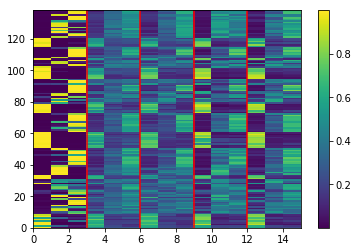

In [17]:
#plt.imshow(matrice_models_for_test, interpolation='nearest', cmap=plt.cm.ocean )
#plt.colorbar()
#plt.show()
plt.pcolor(matrice_models_for_test)
plt.colorbar()
plt.axvline(x=[3], color='r', linestyle='-')
plt.axvline(x=[6], color='r', linestyle='-')
plt.axvline(x=[9], color='r', linestyle='-')
plt.axvline(x=[12], color='r', linestyle='-')
plt.show()

In [ ]:
Y_test_compound = np.argmax(final, axis=1)+1
print("Final Model accuracy from %d compound models is %f" % (trials, accuracy_score(Y_test,Y_test_compound)))

Normalized confusion matrix
[[0.95454545 0.04545455 0.        ]
 [0.06976744 0.51162791 0.41860465]
 [0.01960784 0.1372549  0.84313725]]


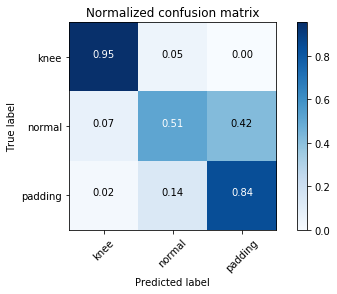

In [18]:
cnf_matrix = confusion_matrix(Y_test,Y_test_compound)
class_names = ['knee', 'normal', 'padding']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 8, 15)             0         
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 8, 128)            40960     
_________________________________________________________________
dropout_49 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_25 (Activation)   (None, 3)                 0         
Total para